# Proyecto Final - Curso 6: Clasificación de Reclamaciones en TikTok

**Objetivo:** Construir un modelo de bosque aleatorio para predecir si un video publicado en TikTok representa una 'reclamación' o una 'opinión'.

**Contexto:** El equipo de datos de TikTok desea automatizar la revisión de informes de usuarios.

## Carga de datos sintéticos

In [23]:
df = pd.read_csv("tiktok_dataset.csv")
print(f"✅ CSV recargado con {len(df)} filas")
print("\n🔍 Valores únicos en claim_status:")
print(df['claim_status'].value_counts(dropna=False))

✅ CSV recargado con 19382 filas

🔍 Valores únicos en claim_status:
claim_status
claim      9608
opinion    9476
NaN         298
Name: count, dtype: int64


In [24]:
original_len = len(df)
df = df.dropna()
print(f"🧽 Eliminadas {original_len - len(df)} filas con NaN ➤ {len(df)} filas restantes")

df['claim_status'] = df['claim_status'].map({'opinión': 0, 'reclamación': 1})
mapped_len = len(df)
df = df.dropna(subset=['claim_status'])
print(f"🔁 Filas válidas tras mapear claim_status: {len(df)} (se perdieron {mapped_len - len(df)})")

df['claim_status'] = df['claim_status'].astype(int)

🧽 Eliminadas 298 filas con NaN ➤ 19084 filas restantes
🔁 Filas válidas tras mapear claim_status: 0 (se perdieron 19084)


In [25]:
print("🕵️ Etiquetas reales encontradas en 'claim_status':")
print(df['claim_status'].dropna().unique())

🕵️ Etiquetas reales encontradas en 'claim_status':
[]


In [26]:
df_raw = pd.read_csv("tiktok_dataset.csv")
print(df_raw['claim_status'].dropna().unique())
print(df_raw[['video_id', 'claim_status']].head(10))

['claim' 'opinion']
     video_id claim_status
0  7017666017        claim
1  4014381136        claim
2  9859838091        claim
3  1866847991        claim
4  7105231098        claim
5  8972200955        claim
6  4958886992        claim
7  2270982263        claim
8  5235769692        claim
9  4660861094        claim


In [27]:
# Volver a cargar si hace falta
df = pd.read_csv("tiktok_dataset.csv")

# Filtro de NaN
df = df.dropna(subset=['claim_status'])

# 🔄 Limpieza segura
df['claim_status'] = df['claim_status'].astype(str).str.strip().str.lower()

# Mapeo inglés ➤ binario
df['claim_status'] = df['claim_status'].map({
    'opinion': 0,
    'claim': 1
})

# Eliminar filas no reconocidas
df = df.dropna(subset=['claim_status'])
df['claim_status'] = df['claim_status'].astype(int)

In [28]:
df = pd.get_dummies(df, columns=['verified_status', 'author_ban_status'], drop_first=True)
print("🔐 Variables categóricas transformadas.")

🔐 Variables categóricas transformadas.


In [29]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'#\w+', '', texto)              # elimina hashtags como "#producto"
    texto = re.sub(r'[^a-záéíóúüñ\s]', ' ', texto)  # elimina símbolos raros como "#", "!", "¿"
    texto = re.sub(r'\s+', ' ', texto).strip()      # quita múltiples espacios
    return texto

# Asegurarse de que la columna existe
if 'video_transcription_text' in df.columns:
    df['video_transcription_text'] = df['video_transcription_text'].fillna('').astype(str)
    df['video_transcription_text'] = df['video_transcription_text'].apply(limpiar_texto)

    if df['video_transcription_text'].str.strip().eq('').all():
        print("⚠️ Todos los textos están vacíos después de limpiar. TF-IDF omitido.")
        X_text = pd.DataFrame(np.zeros((len(df), 1)))
    else:
        tfidf = TfidfVectorizer(
            max_features=50,
            token_pattern=r'\b[a-záéíóúüñ]{3,}\b',  # palabras de ≥3 letras, solo alfabéticas
            min_df=1
        )
        X_text = pd.DataFrame(tfidf.fit_transform(df['video_transcription_text']).toarray())
        print(f"✅ TF-IDF aplicado. Palabras finales: {len(tfidf.vocabulary_)}")
        print("🔤 Vocabulario generado:", tfidf.get_feature_names_out())

    df = df.drop(columns='video_transcription_text', errors='ignore')
else:
    print("⚠️ No existe 'video_transcription_text'. Se omite TF-IDF.")
    X_text = pd.DataFrame(np.zeros((len(df), 1)))

✅ TF-IDF aplicado. Palabras finales: 50
🔤 Vocabulario generado: ['and' 'are' 'around' 'board' 'can' 'claim' 'colleague' 'colleagues'
 'discovered' 'discussion' 'earth' 'family' 'first' 'for' 'forum' 'friend'
 'friends' 'from' 'has' 'have' 'internet' 'learned' 'media' 'more' 'most'
 'news' 'one' 'online' 'only' 'opinion' 'our' 'over' 'read' 'revealed'
 'say' 'social' 'someone' 'than' 'that' 'the' 'their' 'there' 'view' 'was'
 'website' 'were' 'will' 'willing' 'with' 'world']


In [30]:
# Eliminar columna '#' si existe antes de construir X
columnas_a_excluir = ['claim_status', '#']
columnas_existentes = [col for col in columnas_a_excluir if col in df.columns]

X = pd.concat([
    df.drop(columns=columnas_existentes).reset_index(drop=True), 
    X_text
], axis=1)

# Asegurarse de que todas las columnas tienen nombres tipo string
X.columns = X.columns.astype(str)
y = df['claim_status'].reset_index(drop=True)

print(f"✅ X shape: {X.shape} | y shape: {y.shape}")

✅ X shape: (19084, 60) | y shape: (19084,)


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

if len(X) > 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    print("🧠 Modelo entrenado.")
else:
    print("⛔ Dataset vacío tras preprocesamiento. Algo se filtró de más.")

🧠 Modelo entrenado.


In [32]:
from sklearn.metrics import classification_report, roc_auc_score

if len(X) > 0:
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    print("\n📊 Reporte de clasificación:")
    print(classification_report(y_test, y_pred))
    print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")


📊 Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2857
           1       1.00      1.00      1.00      2869

    accuracy                           1.00      5726
   macro avg       1.00      1.00      1.00      5726
weighted avg       1.00      1.00      1.00      5726

AUC: 1.0000


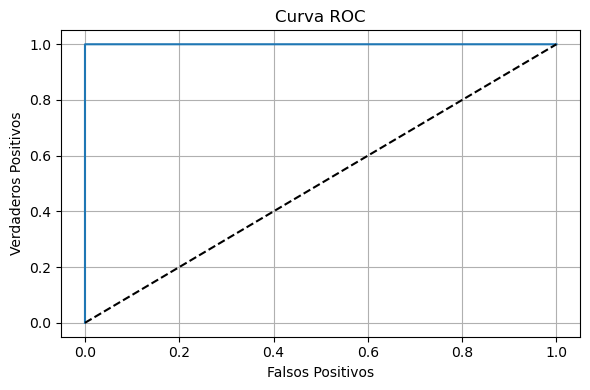

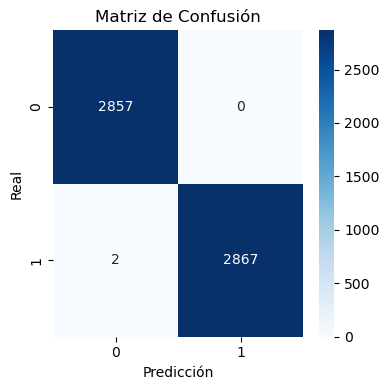

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix

if len(X) > 0:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label='Curva ROC')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('Falsos Positivos')
    plt.ylabel('Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()

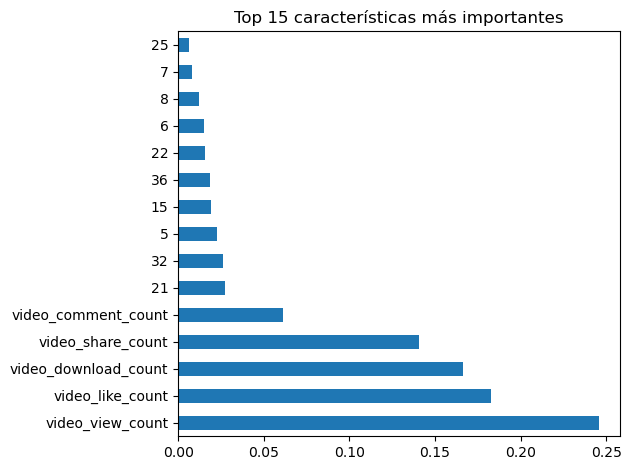

In [34]:
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(15).plot(kind='barh')
plt.title('Top 15 características más importantes')
plt.tight_layout()
plt.show()

Fase 10: Entrenar modelo con XGBoos

In [35]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)
print("🚀 Modelo XGBoost entrenado.")

🚀 Modelo XGBoost entrenado.


In [36]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\n📊 Reporte XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print(f"AUC XGBoost: {roc_auc_score(y_test, y_proba_xgb):.4f}")


📊 Reporte XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2857
           1       1.00      1.00      1.00      2869

    accuracy                           1.00      5726
   macro avg       1.00      1.00      1.00      5726
weighted avg       1.00      1.00      1.00      5726

AUC XGBoost: 1.0000


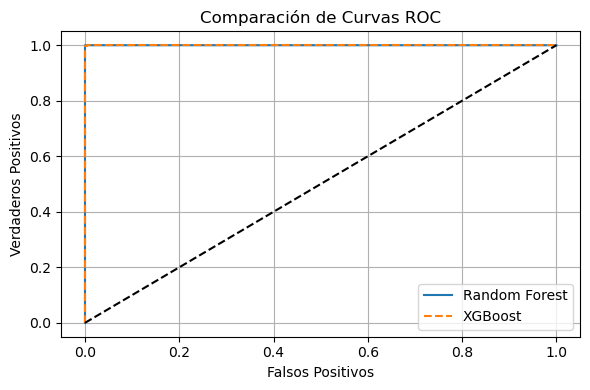

In [37]:
from sklearn.metrics import roc_curve

fpr_rf, tpr_rf, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost', linestyle='--')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Comparación de Curvas ROC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
import numpy as np

xgb_model_cv = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    eval_metric='logloss',
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    xgb_model_cv,
    X,
    y,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

print("📦 AUC por fold:", np.round(scores, 4))
print(f"🎯 Promedio AUC: {scores.mean():.4f} ± {scores.std():.4f}")

📦 AUC por fold: [1. 1. 1. 1. 1.]
🎯 Promedio AUC: 1.0000 ± 0.0000


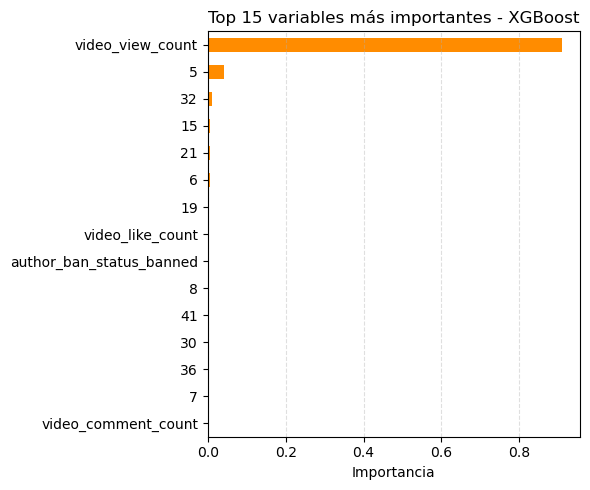

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Obtener importancias
importancias = pd.Series(xgb_model.feature_importances_, index=X.columns)
importancias = importancias.sort_values(ascending=True).tail(15)

# Graficar las 15 más importantes
plt.figure(figsize=(6, 5))
importancias.plot(kind='barh', color='darkorange')
plt.title('Top 15 variables más importantes - XGBoost')
plt.xlabel('Importancia')
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.show()

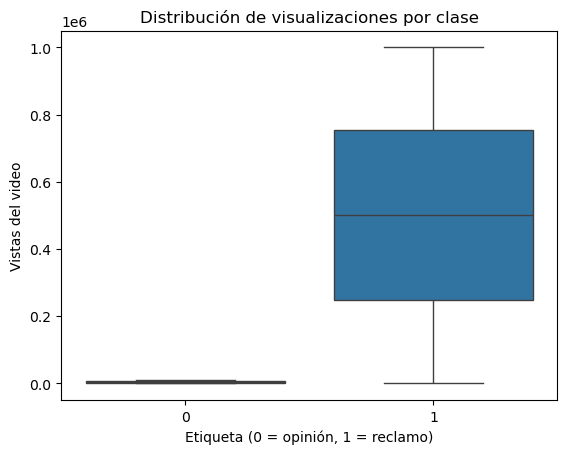

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=y, y=df['video_view_count'])
plt.title('Distribución de visualizaciones por clase')
plt.xlabel('Etiqueta (0 = opinión, 1 = reclamo)')
plt.ylabel('Vistas del video')
plt.show()

In [41]:
X_sin_views = X.drop(columns=['video_view_count'], errors='ignore')

In [42]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

xgb_model_sin_views = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    eval_metric='logloss',
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_sin_views = cross_val_score(
    xgb_model_sin_views,
    X_sin_views,
    y,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

print("📦 AUC por fold (sin video_view_count):", np.round(scores_sin_views, 4))
print(f"🎯 Promedio AUC: {scores_sin_views.mean():.4f} ± {scores_sin_views.std():.4f}")

📦 AUC por fold (sin video_view_count): [1.     0.9998 1.     1.     1.    ]
🎯 Promedio AUC: 1.0000 ± 0.0001


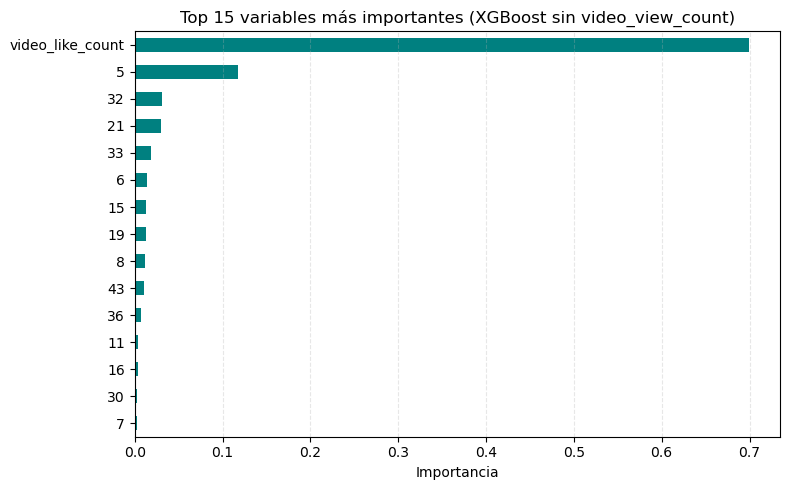

In [44]:
# 1. Entrenamiento del modelo sin 'video_view_count'
from xgboost import XGBClassifier
xgb_model_sin_views = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    eval_metric='logloss',
    random_state=42
)

xgb_model_sin_views.fit(X_sin_views, y)

# 2. Obtener importancia de variables
import pandas as pd
import matplotlib.pyplot as plt

importancias = pd.Series(
    xgb_model_sin_views.feature_importances_,
    index=X_sin_views.columns
)

importancias = importancias.sort_values(ascending=True).tail(15)

# 3. Gráfico
plt.figure(figsize=(8, 5))
importancias.plot(kind='barh', color='teal')
plt.title('Top 15 variables más importantes (XGBoost sin video_view_count)')
plt.xlabel('Importancia')
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.show()